In [1]:
!pip install transformers datasets faiss-cpu -q
!pip install google-api-python-client
!pip install scikit-learn
!pip install requests
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cc8c67649c2e6f7f3563dfcd20b6e67d747bf893b0fd66789d66e567486a22fd
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

# Stanford Sentiment Treebank (SST-2)
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

#Prediction function
def predict_fn(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = model(**encodings)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.cpu().numpy()

explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

def explain_instance(text, num_features=10):
    explanation = explainer.explain_instance(
        text,
        predict_fn,
        num_features=num_features
    )
    return explanation

#Checked it
sample_text = "I really enjoyed this movie. The story was amazing and the actors did a great job."

explanation = explain_instance(sample_text, num_features=10)

print(f"\nExplanation for: \"{sample_text}\"\n")
for label in explanation.available_labels():
    print(f"Label {label} ({explainer.class_names[label]}):")
    for word, weight in explanation.as_list(label=label):
        print(f"  {word:<15} {weight:.4f}")
    print()



Explanation for: "I really enjoyed this movie. The story was amazing and the actors did a great job."

Label 1 (Positive):
  enjoyed         0.0063
  great           0.0063
  amazing         0.0062
  was             -0.0059
  really          0.0052
  and             0.0038
  job             0.0032
  I               -0.0020
  story           0.0019
  a               -0.0015



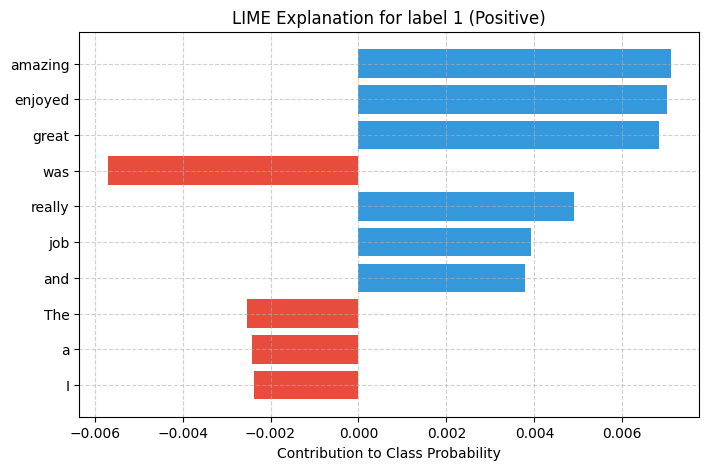

In [7]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

#Fine-tuned model for sentiment analysis
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

#Prediction
def predict_fn(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = model(**encodings)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.cpu().numpy()

#LIME
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

def explain_and_plot(text, num_features=10):
    explanation = explainer.explain_instance(
        text,
        predict_fn,
        num_features=num_features
    )

    for label in explanation.available_labels():
        words, weights = zip(*explanation.as_list(label=label))

        # Cores: vermelho se peso negativo, azul se positivo
        colors = ['#e74c3c' if w < 0 else '#3498db' for w in weights]

        plt.figure(figsize=(8, 5))
        plt.barh(words, weights, color=colors)
        plt.xlabel('Contribution to Class Probability')
        plt.title(f"LIME Explanation for label {label} ({explainer.class_names[label]})")
        plt.gca().invert_yaxis()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#example
sample_text = "I really enjoyed this movie. The story was amazing and the actors did a great job."
explain_and_plot(sample_text, num_features=10)
